In [53]:
import pathlib

import astropy.coordinates as coord
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline

import galstreams
from pyia import GaiaData
from astroquery.gaia import Gaia

In [65]:
data_path = pathlib.Path('../data/').resolve().absolute()
data_path.mkdir(exist_ok=True, parents=True)

In [46]:
streams = {
    'GD-1': 'GD-1-I21',
    'Pal5': 'Pal5-PW19',
    'Jhelum': 'Jhelum-b-B19',
    'Fjorm-M68': 'M68-P19',
    'PS1-A': 'PS1-A-B16',
}
stds = {
    'GD-1': 1.,
    'Pal5': 1.,
    'Jhelum': 2.5,
    'Fjorm-M68': 1.,
    'PS1-A': 1.
}

## Load existing/previously run jobs in the Gaia archive

In [47]:
Gaia.login(
    credentials_file=pathlib.Path('~/.gaia/archive.login').expanduser()
)

INFO:astroquery:Login to gaia TAP server


INFO: Login to gaia TAP server [astroquery.gaia.core]


INFO:astroquery:Login to gaia data server


OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [48]:
jobs = Gaia.list_async_jobs()
jobs = [Gaia.load_async_job(jobid=j.jobid, load_results=False) for j in jobs]
jobs = {j.parameters['jobname']: j for j in jobs if j.is_finished()}

## Define the base query and column names to retrieve:

In [49]:
gaia_columns = [
    'source_id', 
    'ra', 'dec', 
    'parallax', 'parallax_error', 
    'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
    'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 
    'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 
    'parallax_pmdec_corr', 'pmra_pmdec_corr', 
    'phot_g_mean_mag', 'phot_g_mean_flux_over_error', 
    'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error', 
    'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error', 
    'ruwe', 'astrometric_matched_transits'
]

In [50]:
base_query = """
SELECT {columns}
FROM gaiadr3.gaia_source
WHERE parallax < 1 AND bp_rp > -1 AND bp_rp < 4 AND
      CONTAINS(POINT('ICRS', ra, dec), 
               POLYGON('ICRS', 
                       {c[0].ra.degree}, {c[0].dec.degree}, 
                       {c[1].ra.degree}, {c[1].dec.degree}, 
                       {c[2].ra.degree}, {c[2].dec.degree}, 
                       {c[3].ra.degree}, {c[3].dec.degree})) = 1
"""

## Load galstreams tracks:

In [51]:
mws = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


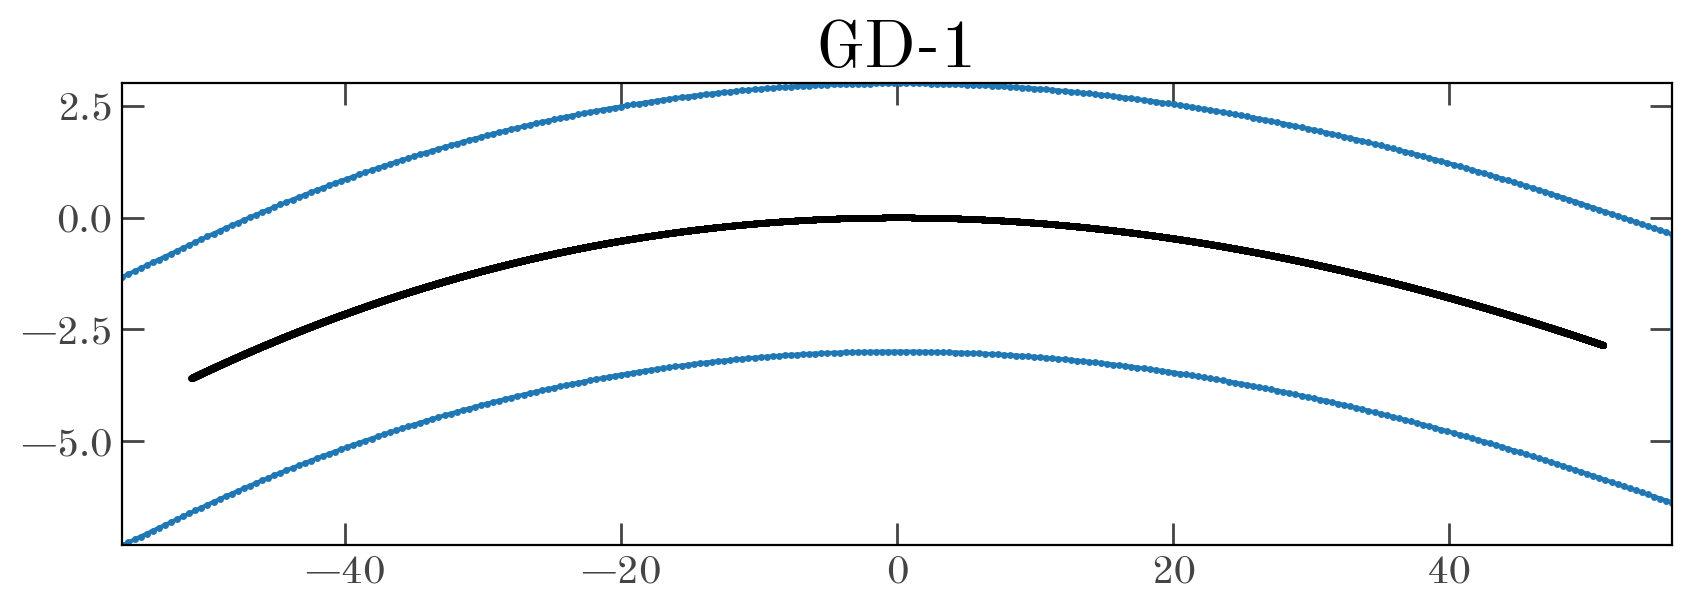

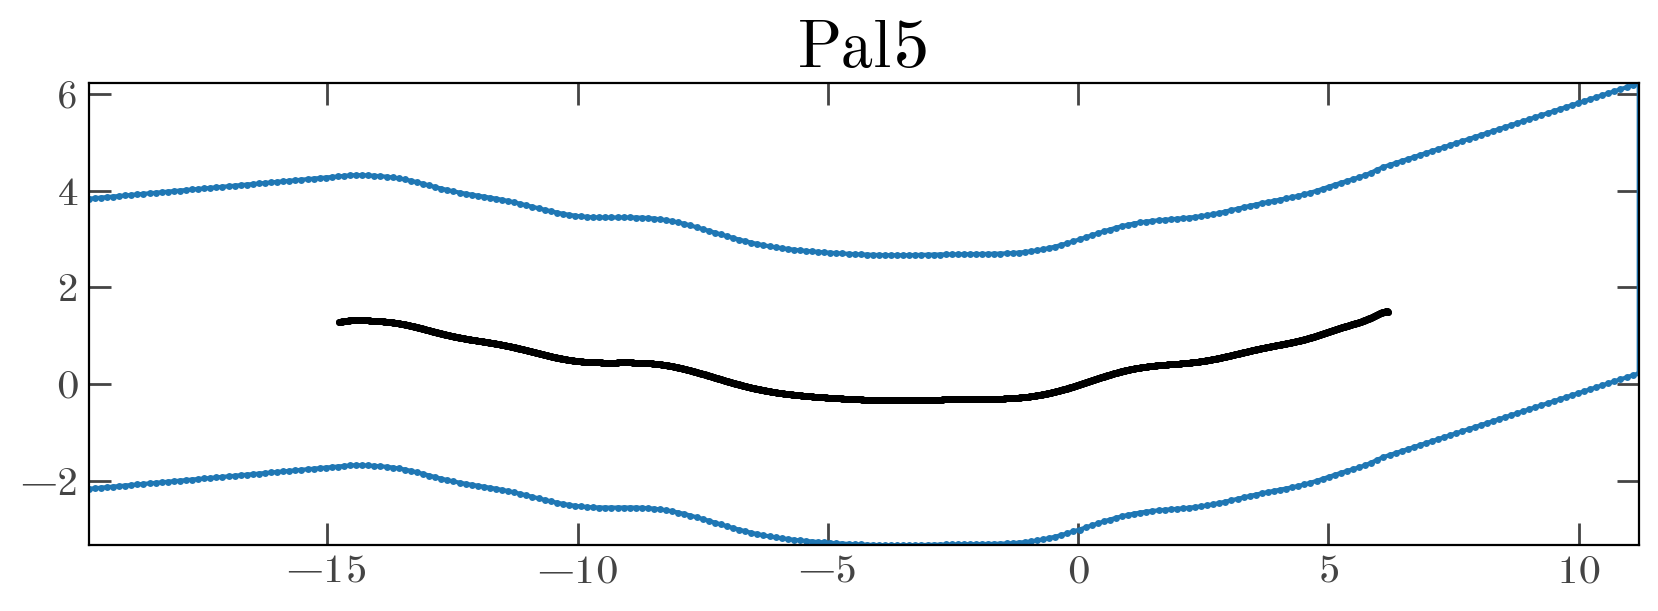

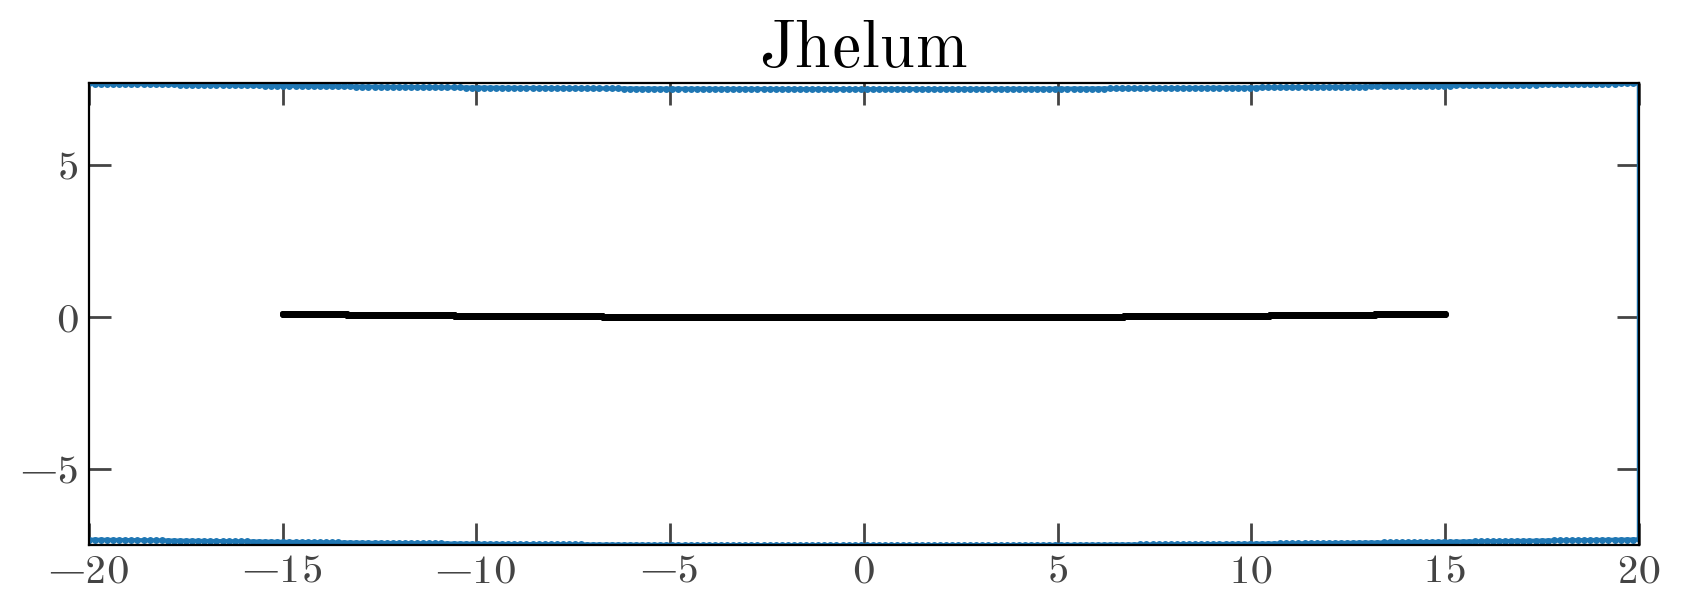

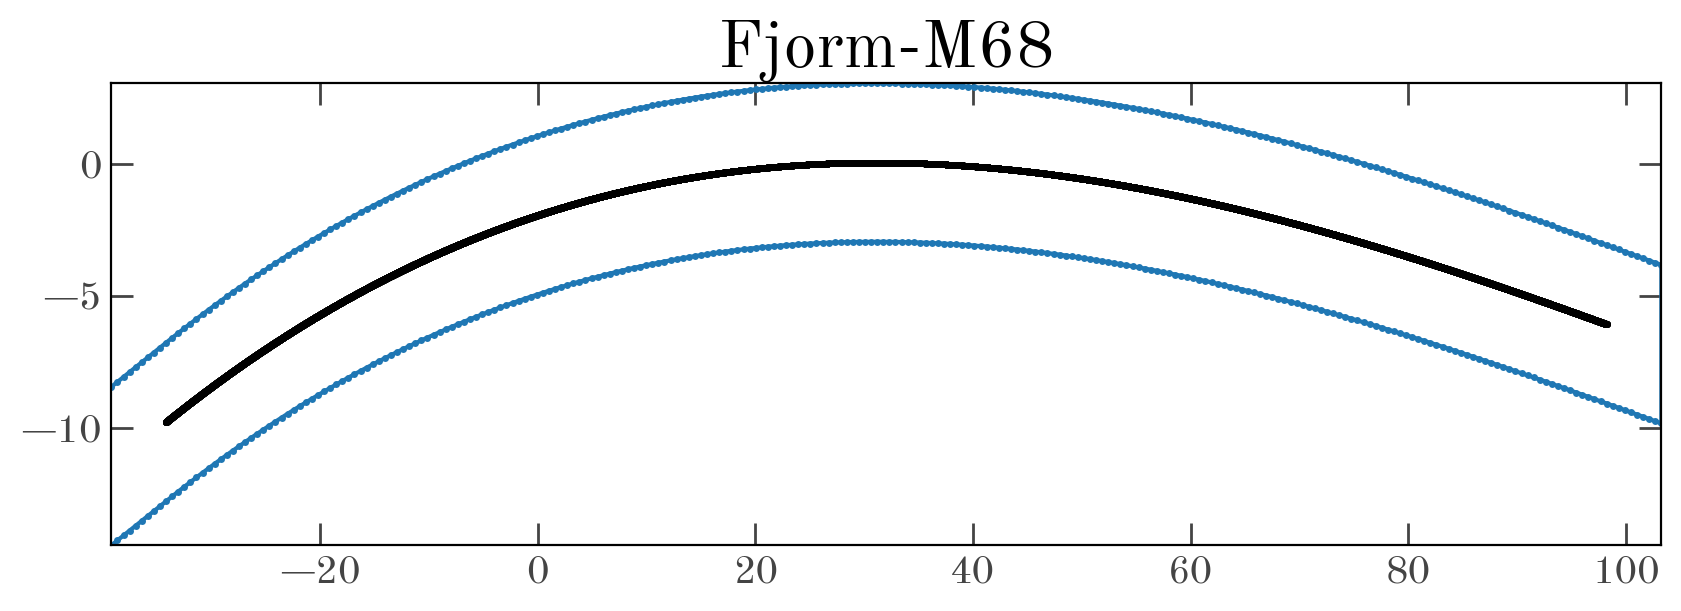

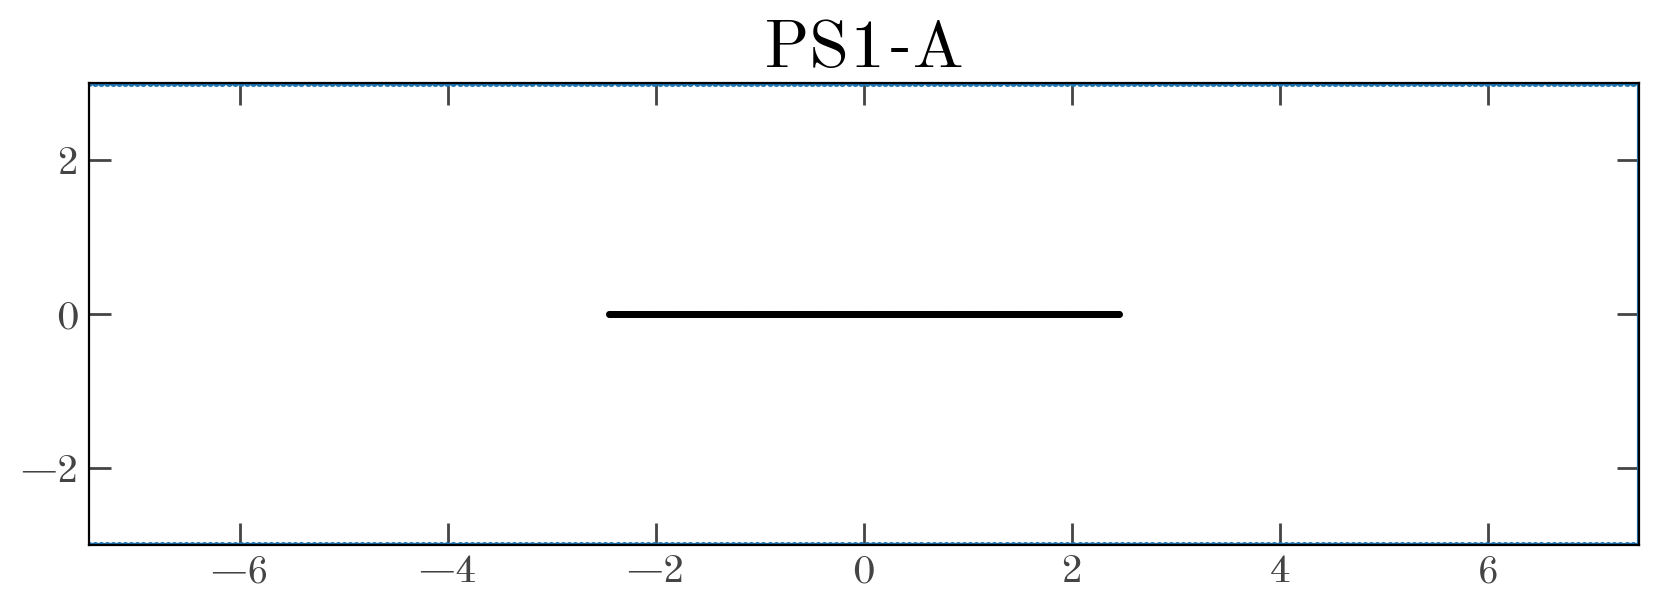

In [105]:
windows = {}
for name, gs_name in streams.items():
    gs = mws[gs_name]
    
    track = gs.track.transform_to(gs.stream_frame)
    
    # extend track by +/- 5 deg in phi1:
    if name == 'Pal5':
        spl = InterpolatedUnivariateSpline(
            track.phi1.degree[20:-10],
            track.phi2.degree[20:-10],
            k=1
        )
    else:
        spl = InterpolatedUnivariateSpline(
            track.phi1.degree,
            track.phi2.degree,
            k=1
        )
    grid_phi1 = np.linspace(
        track.phi1.degree.min() - 5,
        track.phi1.degree.max() + 5,
        256
    )
    grid_phi2 = spl(grid_phi1)
    
    phi1 = np.concatenate((
        grid_phi1,
        grid_phi1[::-1],
    ))
    phi2 = np.concatenate((
        grid_phi2 - 3 * stds[name],
        grid_phi2[::-1] + 3 * stds[name],
    ))
    
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(
        track.phi1.degree,
        track.phi2.degree
    )
    ax.plot(
        phi1,
        phi2,
        color='tab:blue'
    )
    ax.set_title(name)
    
    windows[name] = [(phi1.min(), phi1.max()), (phi2.min(), phi2.max())]
    ax.set_xlim(windows[name][0])
    ax.set_ylim(windows[name][1])

## Run queries

In [106]:
dphi1 = 10.
for name, gs_name in streams.items():
    gs = mws[gs_name]
    
    this_path = data_path / name
    this_path.mkdir(exist_ok=True)
    
    phi1_lim, phi2_lim = windows[name]
    
    phi1_grid = np.clip(np.arange(phi1_lim[0], phi1_lim[1]+dphi1, dphi1), phi1_lim[0], phi1_lim[1])

    _jobs = {}
    for i, (l, r) in enumerate(zip(phi1_grid[:-1], phi1_grid[1:])):
        filename = this_path / f'poly_{i:02d}.fits'
        jobname = f'{name}_{i:02d}'

        print(i, l, r, filename, jobname)

        if filename.exists():
            continue

        elif not filename.exists() and jobname in jobs:
            # TODO: download job and save file
            pass

        else:
            corners = coord.SkyCoord(
                phi1=[l, l, r, r] * u.deg, 
                phi2=[phi2_lim[0], phi2_lim[1], phi2_lim[1], phi2_lim[0]] * u.deg,
                frame=gs.stream_frame
            ).icrs

            query = base_query.format(
                columns=', '.join(gaia_columns), 
                c=corners
            )

            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                job = Gaia.launch_job_async(query, name=jobname, background=True)
            _jobs[filename] = job

    if _jobs:
        for fn, job in _jobs.items():
            tbl = job.get_results()
            tbl.write(fn, overwrite=True)